## Sampling Matters

### Striving for Representativeness

*Data quality* is an important consideration for any data scientist. Quality includes tidyness, trustworthiness, completeness, and so on. The overall *goal* of data quality, however, is to achieve an accurate representation of some real world construct. Hence, when the data comes from a sample of a population, we also consider *representativeness* as a key aspect of data quality, one which often requires careful reasoning.

### Example - A Big Data Fail

Consider the 1936 federal presidential election of FDR vs Al Landon. The magazine *Literary Digest*'s straw poll had correctly predicted the outcome of the previous five presidential elections. Running up to the election, they polled over $10$ million individuals including
    - magazine subscribers
    - registered automobile owners
    - telephone owners
and received responses from about $2.4$ million of those polled. The *Literary Digest* predicted Landon would win in a landslide. By contrast, George Gallup's quota sample consisted of bi-weekly surveys of $2000$ individuals, and correctly predicted a landslide for FDR. 

<img src="qmark.svg" width="30" align="left"> **Question:** what are some potential sources of bias in each of these polling schemes? 

Soln. Possible Answers (elaborate // discuss)
    - non-response bias
    - sampling bias
    - reporting bias
    
    
### Breakdown of Types
    - census
    - sample
        - random
            - simple random 
            - stratified
            - cluster 
            - size-weighted
        - non-random
            - convenience 
            - snowball or referral 
            - quota 

<!---

## Simple Random Sample (SRS)

Given $N$ subjects labelled $\{1,\dots,N\}$, a *SRS* of size $n\le N$ is a random subset of $n$ subjects $A\subseteq \{1,\dots,N\}$ such that observing any subset of $n$ subjects is equally likely. There are ${N\choose n}$ subsets of size $n$, so a SRS satisfies 
$$
\mathbb P\left(A = A_0\right) =  \frac{1}{{N\choose n}},
$$
for any subset $A_0\subseteq\{1,\dots,N\}$ with $n$ elements.
-->

## Computational Considerations

If your dataset is too big...

- You can run out of patience to wait for something to finish running.
- You can run out of memory on one computer

### Rule of Thumb for Computation Time

Usually, Python running on a machine in 2017 can run about 10,000,000 additions per second:

In [29]:
%%timeit
# The timeit Jupyter magic command will run this cell several times, timing each run

additions = 10000000 # 10 million

to_add_1 = 1234567890
to_add_2 = 987654321

for _ in range(additions):
    to_add_1 + to_add_2
print('Done!')

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
797 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check out this website on your own time: https://computers-are-fast.github.io/.

Having a sense of how long things will take helps you a lot when trying to figure out whether you can just wait for something to finish vs. whether you should think of another solution (eg. better algorithm, distributed computing, etc.)

### Obtain a SRS with Python

Some methods have different runtimes than others. Let's compare `np.random.choice` and Python's built-in `random.sample`:

In [16]:
import numpy as np
import random

N = 50000
n = 100

# using numpy - returns an array of shape (n,)
np.random.choice(range(N),n,replace=False)

# using random module - returns a list of length n
random.sample(range(N),n)[:5]

[26572, 21837, 41044, 49791, 6446]

### Wall-Clock Time Efficiency

In [20]:
from timeit import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context("poster")

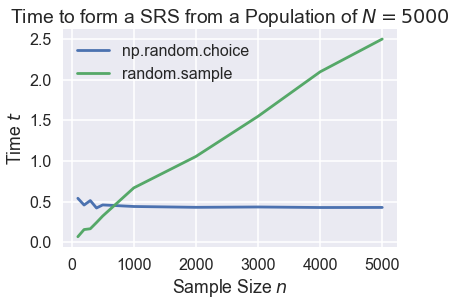

In [21]:
nn = [100,200,300,400,500,1000,2000,3000,4000,5000]
t0 = []
t1 = []

for n in nn:
    t0.append(timeit(setup="import numpy as np",
                     stmt="np.random.choice(a=range(5000),size=%d,replace=False)" % n,
                     number=500))

    t1.append(timeit(setup="import random",
                     stmt="random.sample(range(5000),%d)" % n,
                     number=500))

plt.plot(nn,t0)
plt.plot(nn,t1)
plt.xlabel("Sample Size $n$")
plt.ylabel("Time $t$")
plt.title("Time to form a SRS from a Population of $N=5000$")
plt.legend(["np.random.choice","random.sample"])

plt.show()

<img src="qmark.svg" width="30" align="left"> **Question:** What do you notice about this plot?

### Scale of the SRS

In the Powerball, there are $N=69$ white balls in a cage, numbered $1$ through $69$, and in the first part of the lottery, $n=5$ are sampled without replacement by repeatedly sampling a white ball uniformly from the remaining subset.

<img src="qmark.svg" width="30" align="left"> **Question:** How likely is each subset of five balls?

Soln.
$$
{N\choose n} = \frac{69!}{5!\cdot64!} = \frac{69\cdots 65}{5!} = 11,238,513
$$

In lecture, we looked at samples of $n=400$ women in the US aged $40$-$44$, a population of $N=8700000$ individuals (luckily, we knew ahead of time the fraction of such women with $1,2,3,$ or $4$ children). Now the number of possible subsets is
$$
{N\choose n} \approx 9.94 \cdot 10^{1906}.
$$

### Big populations

<img src="qmark.svg" width="30" align="left"> **Question:** How would you simulate a sample of size 400 from the population of US women in Python? Is this feasible to do?

<img src="qmark.svg" width="30" align="left"> **Question:** Facebook generates about 2.7 billion Likes a day. That means there are about 1 trillion likes per year. How would you take a sample from their Likes database? Is this feasible to do?

### Reservoir Sampling

In some applications requiring a SRS, the size of the population $N$ is not known beforehand or is expensive to compute. The population can be read sequentially, say as lines in a csv file, but the file is too big to load into memory (eg. Facebook's database). Counting the lines $N$ would require its own pass through the lines of the file. Fortunately, there's a clever way to obtain a SRS in one pass over the data even when the size of the population is unknown.

https://www.wikiwand.com/en/Reservoir_sampling

In [26]:
import random

def reservoir_sample(iterator, n):
    sample, N = [], 0 # initialize
    for item in iterator:
        N += 1
        # take the first n elements automatically
        if len(sample) < n: 
            sample.append(item)
        # add the next element to a random position s if s < n
        else:
            s = random.randint(0,N-1)
            if s < n:
                sample[s] = item
        print(sample)
        print(item)
    return sample

In [7]:
# check that this makes each subset equally likely in a small example
from collections import Counter
tag = lambda x: 2**x[0] + 2**x[1]

S = 1000000
samples = [tuple(sorted(reservoir_sample([1,2,3,4],2))) for _ in range(S)]
Counter(samples)

Counter({(1, 2): 166878,
         (1, 3): 166821,
         (1, 4): 166950,
         (2, 3): 166968,
         (2, 4): 165777,
         (3, 4): 166606})

## Probability Sampling for Attributes

This material is optional and is intended for students with more background in probability. These ideas are essential for understanding how different sampling schemes work, but won't be tested (until perhaps a later course).

### SRS
Suppose we have a single Urn with $N$ balls which are identical but for their color, with $N_R < N$ of them red and $N_G = N-N_R$ of them green. Suppose we sample $n$ balls from the urn without replacement and observe exactly $x\in\{0,\dots,n\}$ red balls. There were $N_R$ red balls to choose the $x$ from, and $N_G$ green balls to choose the remaining $n-x$ from, so there are ${N_R\choose x} {N_G\choose n-x}$ possible subsets with exactly $x$ red balls. Since there are ${N\choose n}$ possible subsets, each of which is equally likely, the probability of observing exactly $x$ red balls is 
$$
\frac{{N_R\choose x} {N_G\choose n-x}}{{N\choose n}}.
$$

<img src="qmark.svg" width="30" align="left"> **Question:** What is the average number of red balls in the SRS?

Soln. 
\begin{align*}
\sum_{x=1}^{N_R} x \frac{{N_R\choose x} {N_G\choose n-x}}{{N\choose n}} 
&= \sum_{x=1}^{N_R} N_R \frac{{N_R - 1\choose x-1} {N_G\choose n-x}}{{N\choose n}} \\
&= \frac{N_Rn}{N}\sum_{x=1}^{N_R}  \frac{{N_R - 1\choose x-1} {N_G\choose n-x}}{\frac{n}{N}{N\choose n}} \\
&= \frac{N_Rn}{N}\sum_{x=1}^{N_R}  \frac{{N_R - 1\choose x-1} {N_G\choose n-x}}{{N-1\choose n - 1}} \\
&= \frac{N_Rn}{N}\underbrace{\sum_{x=0}^{N_R-1}  \frac{{N_R - 1\choose x} {N_G\choose n-1-x}}{{N-1\choose n - 1}}}_{=1} \\
&= \frac{N_Rn}{N}
\end{align*}

Another way of phrasing this is that if we observe $x$ red balls from a SRS of $n$ balls from an urn, on average our estimate $\frac{x}{n}$ of the proportion $\frac{N_R}{N}$ will be correct!

### Stratified Random Sample

In Stratified Sampling, we divide the population into distinct subpopulations called *strata* and obtain random samples from each stratum. If we care about studying each subpopulation on its own or comparing them, of course it makes sense to stratify. But we are only asking questions about the entire population, we might still turn to stratification if:
   - It is more feasible. For example, geographic stratification in a large scale household study can organize the data collection effort and allow the surveyor to allocate a fixed amount of resources to studying each region.
   - It can lead to more precise estimates.

To understand the latter we return to the urn model. Now the balls are divided into $K$ urns, each with $N^{(k)}$ balls, such that $\sum_{k=1}^KN^{(k)} = N$. Similarly each stratum contains $N_R^{(k)}$ and $N_G^{(k)}$ red and green balls, respectively, so $N^{(k)} = N_R^{(k)} + N_G^{(k)}$. We sample $n^{(k)}$ without replacement from each stratum and $n = \sum_{k=1}^K n^{(k)}$ balls in total. Suppose we observe $x^{(k)}$ red balls in each urn, and estimate the proportion with the weighted average

$$
\sum_{k=1}^K \left(\frac{N^{(k)}}{N}\right)\frac{x^{(k)}}{n^{(k)}}.
$$

<img src="qmark.svg" width="30" align="left"> **Question:** What's the average value of the proportion?

Soln. We know from SRS that the average value of $\frac{x^{(k)}}{n^{(k)}}$ is $\frac{N_R^{(k)}}{N^{(k)}}$. Hence the average value of our weighted proportion is 

$$
\sum_{k=1}^K \left(\frac{N^{(k)}}{N}\right)\frac{N_R^{(k)}}{N^{(k)}} = \sum_{k=1}^K \frac{N_R^{(k)}}{N},
$$

which simplifies to 

$$
\frac{N_R}{N}.
$$

The weighted proportion is right on average as well!

### Clustered Random Sample

In Cluster Sampling, we group the $N$ balls into $C$ equally sized clusters. Now the urn is filled with $C$ packets, each with $\frac{N}{C}$ balls, and we pick out $\frac{nC}{N}$ packets to observe a total of $n$ balls. If $x^{(c)}$ denotes the number of red balls in cluster $c$, and we observe a subset of clusters $\mathcal O \subset \{1,\dots,C\}$, the proportion

$$
\frac{1}{n}\sum_{c\in \mathcal O}x^{c},
$$

is also right on average.

<img src="qmark.svg" width="30" align="left"> **Question:** Which sampling procedure should we prefer for measuring the presence of an attribute?

In [56]:
def SRS(n,URN):
    flattened_urn = URN.flatten()
    return np.mean(np.random.choice(flattened_urn,n,replace=False))

def SS(n,URN):
    K = URN.shape[0]
    return np.mean([np.random.choice(URN[k,:],int(n/K),replace=False) for k in range(K)])

def CS(n,URN):
    cluster_size, n_clusters = URN.shape
    return URN[:, np.random.choice(C, n // cluster_size, replace=False)].mean()

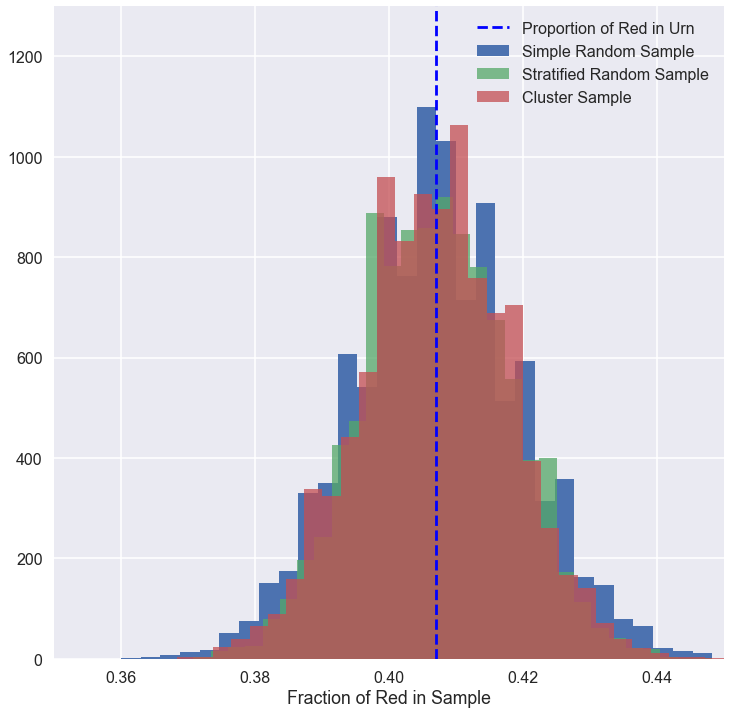

In [61]:
S = 10000
K=3
pk = [0.25,0.75,0.2]
C=2000

URN = np.array([np.random.binomial(1,pk[k],size=C) for k in range(K)])
p = np.mean(URN) # true proportion of reds in URN

plt.figure(figsize=(12, 12))
plt.hist([SRS(1200,URN)  for _ in range(S)],bins=30,alpha=1., label="Simple Random Sample")
plt.hist([SS(1200,URN) for _ in range(S)],bins=30,alpha=0.75, label="Stratified Random Sample")
plt.hist([CS(1200,URN) for _ in range(S)],bins=30,alpha=0.75, label="Cluster Sample")
plt.plot([p,p],[0,1300],'b--', label="Proportion of Red in Urn")
plt.axis([0.35,0.45,0,1300])
plt.legend()
plt.xlabel("Fraction of Red in Sample")
plt.show()

<img src="qmark.svg" width="30" align="left"> **Question:** What does this plot mean? What do you notice?

Read these links on when different sampling techniques are useful:

- https://www.wikiwand.com/en/Stratified_sampling#/Advantages
- https://www.wikiwand.com/en/Cluster_sampling#/Applications_of_cluster_sampling